In [1]:
import pandas as pd
import re
from post_processing import error_estimation, merge_estimates_true

# Utils

In [2]:
pretty_methods = {'Holdout': 'Holdout', 
                'Repeated_Holdout': 'Repeated Holdout', 
                'RepeatedHoldout': 'Repeated Holdout', 
                'Growing_Window': 'Growing Window',
                'GrowingWindow': 'Growing Window', 
                'Rolling_Window': 'Rolling Window',
                'RollingWindow': 'Rolling Window',
                'Block_CV': 'Block CV',
                'BlockCV': 'Block CV', 
                'AdaptedhvBlockCV': 'Adapted hv-Block CV', 
                'MarkovCV': 'Markov CV',
                'BlockCV_with_weights_paper': 'Weighted Block CV var.1', 
                'BlockCV_with_weights': 'Weighted Block CV var.2',
                'GrowingWindow_with_weights': 'Weighted Growing Window', 
                'RollingWindow_with_weights': 'Weighted Rolling Window',
                'Block_CV_with_weights_paper': 'Weighted Block CV var.1', 
                'Block_CV_with_weights': 'Weighted Block CV var.2',
                'Growing_Window_with_weights': 'Weighted Growing Window', 
                'Rolling_Window_with_weights': 'Weighted Rolling Window'}

In [3]:
def clean_filename(filepath, st_split = '/'):
    filename = filepath.split(st_split)[-1]
    
    filename = filename.rsplit('.', 1)[0]
    
    # Check if the filename ends with a date in the format DDMMYYYY or similar
    # and remove the date if it exists
    filename = re.sub(r'_\d{8}$', '', filename)
    
    return filename

def clean_method(method_str):
    parts = method_str.split('.')
    if len(parts) > 3:
        method_name = parts[3].split()[0]
    else:
        method_name = parts[-1].split()[0]
    return method_name

def prettify(df, pretty_methods: dict = pretty_methods):
    copy = df.copy()
    copy['method'] = copy['method'].map(pretty_methods)
    return copy

## Upload

In [4]:
real_data_test = pd.read_csv('results/real_data_test.csv')
real_data_val = pd.read_csv('results/real_data_val.csv')
syn_data_test = pd.read_csv('results/syn_data_test.csv')
syn_data_val = pd.read_csv('results/syn_data_val.csv')
stats = pd.read_csv('results/time_series_stats.csv')

# Friedman Test

In [5]:
data_val, data_test = real_data_val, real_data_test

In [8]:
est = error_estimation(syn_data_val)
estimates = merge_estimates_true(est, syn_data_test)

In [9]:
estimates['PAE'] = estimates['mse_estimate'] - estimates['mse_true']
for_friedman = estimates[estimates['model'] == 'ARMA'][['Field', 'series', 'method', 'PAE']].copy()
for_friedman

,Field,series,method,PAE
0,s1,s1_0,Adapted hv-Block CV,-8.922074e-01
3,s1,s1_0,Block CV,-8.806334e-01
6,s1,s1_0,Growing Window,-9.177595e-01
9,s1,s1_0,Holdout,-9.789598e-01
12,s1,s1_0,Markov CV,-3.865877e-01
...,...,...,...,...
98985,s3,s3_999,Rolling Window,3.648251e+06
98988,s3,s3_999,Weighted Block CV var.1,-2.349323e+06
98991,s3,s3_999,Weighted Block CV var.2,-2.770557e+06
98994,s3,s3_999,Weighted Growing Window,-1.387184e+06


In [10]:
import pandas as pd
from scipy.stats import friedmanchisquare

# Assuming for_friedman is your DataFrame
# Example structure of for_friedman:
# | Field | series | method | PAE |
# |-------------------------|------------|--------|---------|
# | Process1                | 1          | M1     | 0.85    |
# | Process1                | 1          | M2     | 0.80    |
# | ...                     | ...        | ...    | ...     |
# | Process2                | 1000       | M10    | 0.75    |

# Reshape the data to have a row for each dataset_id and columns for each method's measures
pivot_df = for_friedman.pivot_table(index=['Field', 'series'], columns='method', values='PAE')

# Perform the Friedman test
# Group by 'Field' and apply the Friedman test
def apply_friedman(group):
    # Perform the Friedman test
    return friedmanchisquare(*[group[method].dropna() for method in group.columns])

friedman_results = pivot_df.groupby('Field').apply(apply_friedman)

# Display the results
print(friedman_results)

# If you want to present the results in a more readable format, you can create a summary DataFrame
summary_df = pd.DataFrame(friedman_results.tolist(), index=friedman_results.index, columns=['Statistic', 'p-value'])

#import ace_tools as tools
#tools.display_dataframe_to_user(name="Friedman Test Results Summary", dataframe=summary_df)

summary_df


Field
s1    (1806.3441818181818, 0.0)
s2    (2032.8287272727248, 0.0)
s3     (2723.108909090908, 0.0)
dtype: object


,Statistic,p-value
Field,,
s1,1806.344182,0.0
s2,2032.828727,0.0
s3,2723.108909,0.0


Fields with significant differences (p < 0.05): Index(['s1', 's2', 's3'], dtype='object', name='Field')
Average Ranks for Significant Fields:
method  Adapted hv-Block CV  Block CV  Growing Window  Holdout  Markov CV  \
Field                                                                       
s1                    5.896     5.307           5.548    5.023      9.839   
s2                    5.427     5.027           5.719    5.171      9.888   
s3                    7.707     7.375           6.109    4.537      9.677   

method  Repeated Holdout  Rolling Window  Weighted Block CV var.1  \
Field                                                               
s1                 5.051           6.778                    5.364   
s2                 5.183           7.110                    5.177   
s3                 3.807           6.585                    5.059   

method  Weighted Block CV var.2  Weighted Growing Window  \
Field                                                      
s1    

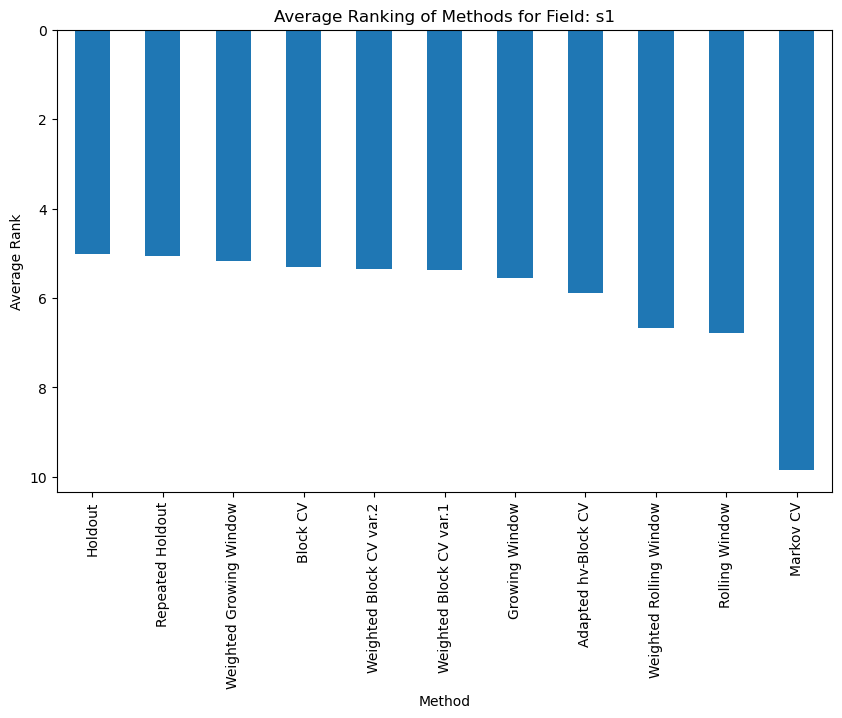

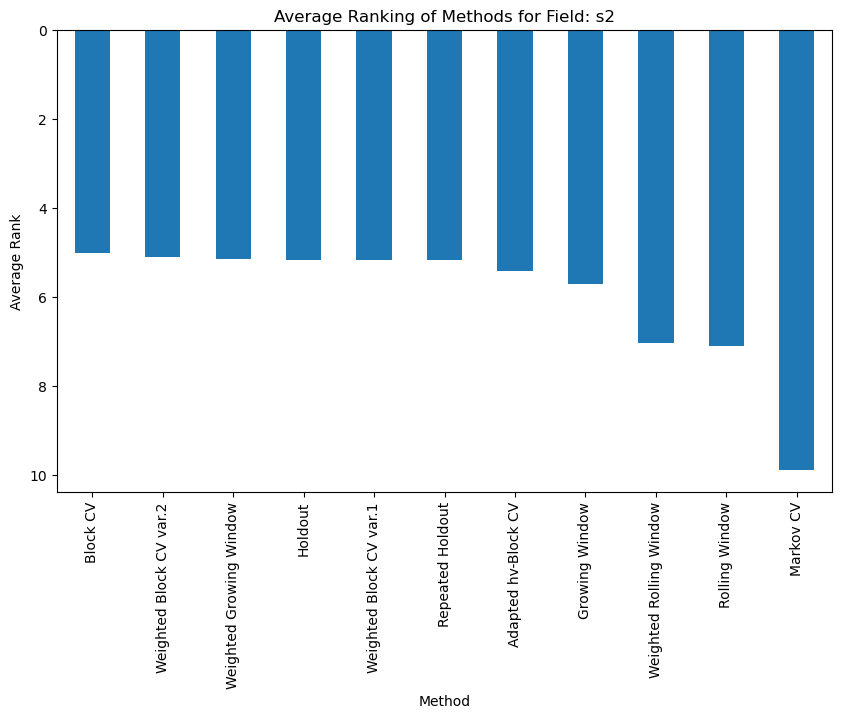

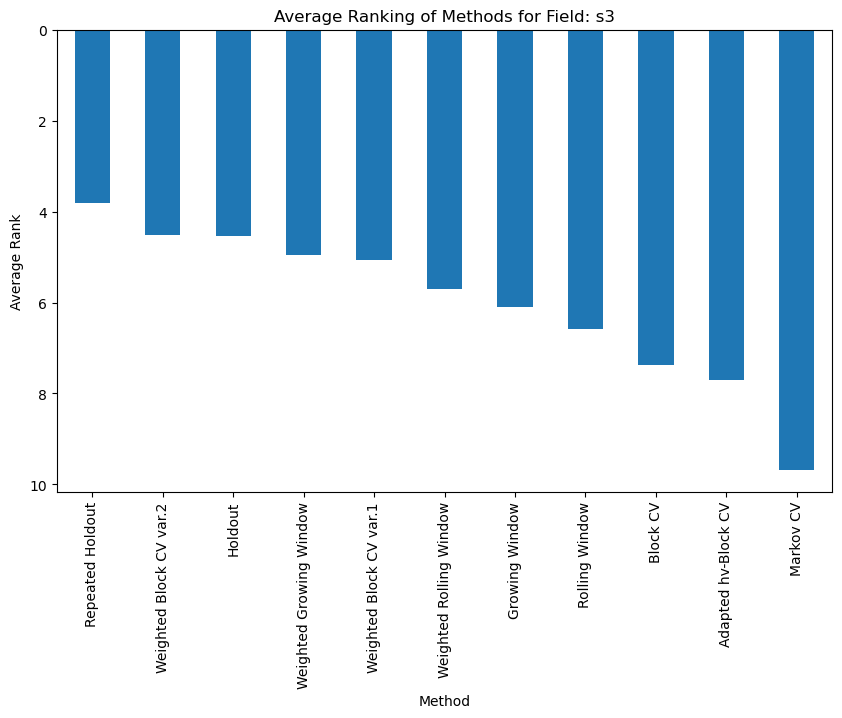

In [11]:
import pandas as pd
from scipy.stats import friedmanchisquare
import numpy as np
import matplotlib.pyplot as plt

# Pivot the data to have methods as columns
pivot_df = for_friedman.pivot_table(index=['Field', 'series'], columns='method', values='PAE')

# Function to calculate ranks and Friedman test
def calculate_ranks_and_friedman(group):
    # Calculate ranks for each row (series)
    ranks = group.rank(axis=1, method='average')
    
    # Calculate average ranks for each method
    average_ranks = ranks.mean(axis=0)
    
    # Perform the Friedman test
    stat, p_value = friedmanchisquare(*[group[method].dropna() for method in group.columns])
    
    return average_ranks, stat, p_value

# Apply the function to each group by 'Field'
results = pivot_df.groupby('Field').apply(calculate_ranks_and_friedman)

# Extract the average ranks, statistics, and p-values
average_ranks = results.apply(lambda x: x[0])
friedman_stats = results.apply(lambda x: x[1])
p_values = results.apply(lambda x: x[2])

# Check for statistical significance
significant_fields = p_values[p_values < 0.05].index
print(f"Fields with significant differences (p < 0.05): {significant_fields}")

# Display the average ranks for significant fields
average_ranks_significant = average_ranks.loc[significant_fields]
print("Average Ranks for Significant Fields:")
print(average_ranks_significant)

# Visualize the average ranks
for field in significant_fields:
    plt.figure(figsize=(10, 6))
    avg_ranks = average_ranks.loc[field]
    avg_ranks.sort_values().plot(kind='bar')
    plt.title(f'Average Ranking of Methods for Field: {field}')
    plt.xlabel('Method')
    plt.ylabel('Average Rank')
    plt.gca().invert_yaxis()  # Invert y-axis to have lower rank at top
    plt.show()


Fields with significant differences (p < 0.05): Index(['s1', 's2', 's3'], dtype='object', name='Field')
Average Ranks for Significant Fields:
method  Adapted hv-Block CV  Block CV  Growing Window  Holdout  Markov CV  \
Field                                                                       
s1                    5.896     5.307           5.548    5.023      9.839   
s2                    5.427     5.027           5.719    5.171      9.888   
s3                    7.707     7.375           6.109    4.537      9.677   

method  Repeated Holdout  Rolling Window  Weighted Block CV var.1  \
Field                                                               
s1                 5.051           6.778                    5.364   
s2                 5.183           7.110                    5.177   
s3                 3.807           6.585                    5.059   

method  Weighted Block CV var.2  Weighted Growing Window  \
Field                                                      
s1    

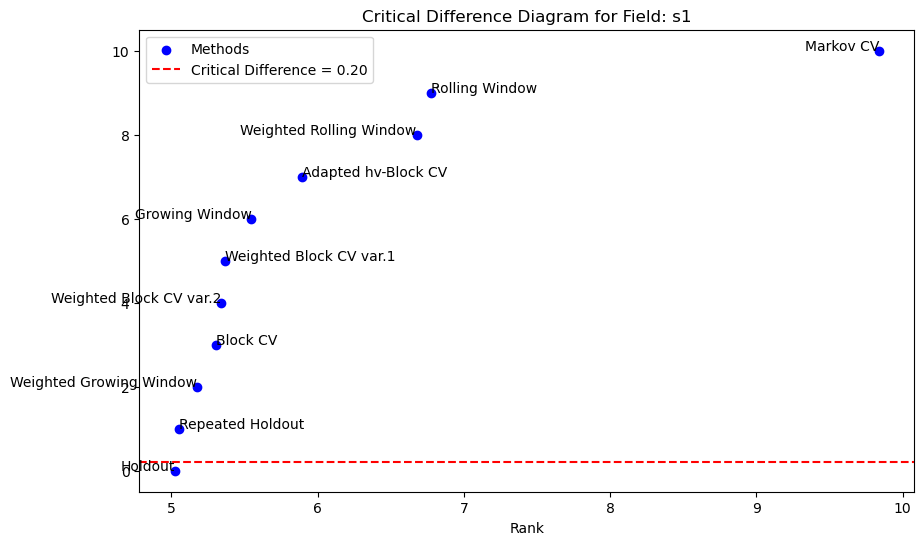

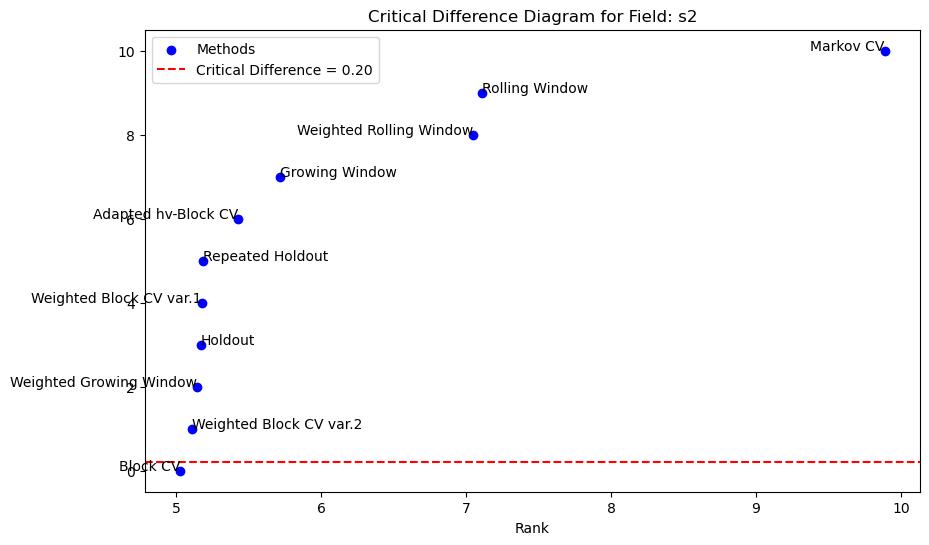

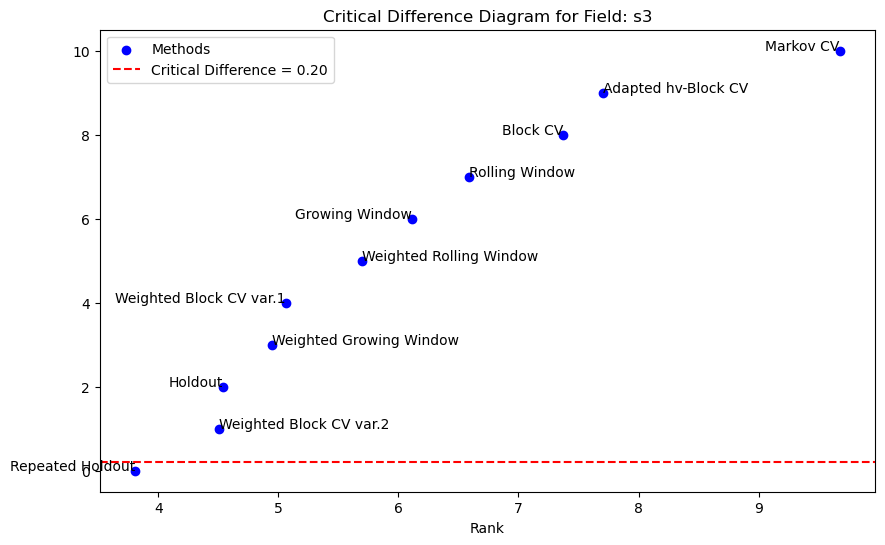

In [12]:
import pandas as pd
from scipy.stats import friedmanchisquare, rankdata
import scikit_posthocs as sp
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace this with your actual DataFrame)
# for_friedman = pd.read_csv('your_data.csv')  # Uncomment and use your data file

# Pivot the data to have methods as columns
pivot_df = for_friedman.pivot_table(index=['Field', 'series'], columns='method', values='PAE')

# Function to calculate ranks and Friedman test
def calculate_ranks_and_friedman(group):
    # Calculate ranks for each row (series)
    ranks = group.rank(axis=1, method='average')
    
    # Calculate average ranks for each method
    average_ranks = ranks.mean(axis=0)
    
    # Perform the Friedman test
    stat, p_value = friedmanchisquare(*[group[method].dropna() for method in group.columns])
    
    return average_ranks, stat, p_value

# Apply the function to each group by 'Field'
results = pivot_df.groupby('Field').apply(calculate_ranks_and_friedman)

# Extract the average ranks, statistics, and p-values
average_ranks = results.apply(lambda x: x[0])
friedman_stats = results.apply(lambda x: x[1])
p_values = results.apply(lambda x: x[2])

# Check for statistical significance
significant_fields = p_values[p_values < 0.05].index
print(f"Fields with significant differences (p < 0.05): {significant_fields}")

# Display the average ranks for significant fields
average_ranks_significant = average_ranks.loc[significant_fields]
print("Average Ranks for Significant Fields:")
print(average_ranks_significant)

# Function to plot critical difference diagram
def plot_cd_diagram(ranks, title):
    # Number of methods
    k = len(ranks)
    # Number of datasets (assumes balanced data)
    N = len(pivot_df.index.levels[1])
    
    # Compute critical difference
    q_alpha = 2.326  # For alpha = 0.05 in the Nemenyi test
    cd = q_alpha * np.sqrt(k * (k + 1) / (6.0 * N))
    
    # Sort ranks
    sorted_ranks = ranks.sort_values()
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel('Rank')
    plt.scatter(sorted_ranks.values, range(k), label='Methods', color='blue')
    
    for i, (method, rank) in enumerate(sorted_ranks.items()):
        plt.text(rank, i, method, ha='right' if i % 2 == 0 else 'left')
    
    # Plot critical difference
    plt.axhline(y=cd, color='red', linestyle='--', label=f'Critical Difference = {cd:.2f}')
    plt.legend()
    plt.show()

# Plot critical difference diagrams for significant fields
for field in significant_fields:
    plot_cd_diagram(average_ranks.loc[field], f'Critical Difference Diagram for Field: {field}')


In [13]:
import pandas as pd
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace this with your actual DataFrame)
# for_friedman = pd.read_csv('your_data.csv')  # Uncomment and use your data file
for_friedman['PAE'] = pd.to_numeric(for_friedman['PAE'], errors='coerce')

# Pivot the data to have methods as columns
pivot_df = for_friedman.pivot_table(index=['Field', 'series'], columns='method', values='PAE')

# Function to calculate ranks and Friedman test
def calculate_ranks_and_friedman(group):
    # Calculate ranks for each row (series)
    ranks = group.rank(axis=1, method='average')
    
    # Calculate average ranks for each method
    average_ranks = ranks.mean(axis=0)
    
    # Perform the Friedman test
    stat, p_value = friedmanchisquare(*[group[method].dropna() for method in group.columns])
    
    return average_ranks, stat, p_value, ranks

# Apply the function to each group by 'Field'
results = pivot_df.groupby('Field').apply(calculate_ranks_and_friedman)

# Extract the average ranks, statistics, p-values, and individual ranks
average_ranks = results.apply(lambda x: x[0])
friedman_stats = results.apply(lambda x: x[1])
p_values = results.apply(lambda x: x[2])
ranks = results.apply(lambda x: x[3])

# Check for statistical significance
significant_fields = p_values[p_values < 0.05].index
print(f"Fields with significant differences (p < 0.05): {significant_fields}")

friedman_stats


Fields with significant differences (p < 0.05): Index(['s1', 's2', 's3'], dtype='object', name='Field')


Field
s1    1806.344182
s2    2032.828727
s3    2723.108909
dtype: float64

In [14]:
p_values

Field
s1    0.0
s2    0.0
s3    0.0
dtype: float64

In [15]:
from scipy.stats import friedmanchisquare

# Assume for_friedman is your DataFrame
# Example structure of for_friedman:
# | Field | series | method | PAE |
# |-------------------------|------------|--------|---------|
# | Process1                | 1          | M1     | 0.85    |
# | Process1                | 1          | M2     | 0.80    |
# | ...                     | ...        | ...    | ...     |
# | Process2                | 1000       | M10    | 0.75    |


# Reshape the data to have a row for each dataset_id and columns for each method's measures
pivot_df = for_friedman.pivot_table(index=['Field', 'series'], columns='method', values='PAE')

# Perform the Friedman test
# We'll assume that there are 10 methods, named M1, M2, ..., M10
friedman_results = pivot_df.groupby('Field').apply(lambda group: friedmanchisquare(*[group[method] for method in group.columns]))

# Display the results
print(friedman_results)

# If you want to present the results in a more readable format, you can create a summary DataFrame
summary_df = pd.DataFrame(friedman_results, columns=['Statistic', 'p-value'])
#import ace_tools as tools; tools.display_dataframe_to_user(name="Friedman Test Results Summary", dataframe=summary_df)
friedman_results


Field
s1    (1806.3441818181818, 0.0)
s2    (2032.8287272727248, 0.0)
s3     (2723.108909090908, 0.0)
dtype: object


ValueError: Shape of passed values is (3, 1), indices imply (3, 2)

In [ ]:
import pandas as pd
from scipy.stats import friedmanchisquare

# Assume df is your DataFrame
# Example structure of df:
# | data_generating_process | dataset_id | method | measure |
# |-------------------------|------------|--------|---------|
# | Process1                | 1          | M1     | 0.85    |
# | Process1                | 1          | M2     | 0.80    |
# | ...                     | ...        | ...    | ...     |
# | Process2                | 1000       | M10    | 0.75    |

# Load your data into a DataFrame
# df = pd.read_csv('your_file.csv')

# Reshape the data to have a row for each dataset_id and columns for each method's measures
pivot_df = df.pivot_table(index=['data_generating_process', 'dataset_id'], columns='method', values='measure')

# Perform the Friedman test
# We'll assume that there are 10 methods, named M1, M2, ..., M10
friedman_results = pivot_df.groupby('data_generating_process').apply(lambda group: friedmanchisquare(*[group[method] for method in group.columns]))

# Display the results
print(friedman_results)

# If you want to present the results in a more readable format, you can create a summary DataFrame
summary_df = pd.DataFrame(friedman_results, columns=['Statistic', 'p-value'])
import ace_tools as tools; tools.display_dataframe_to_user(name="Friedman Test Results Summary", dataframe=summary_df)


NameError: name 'df' is not defined